In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("data/train-images-idx3-ubyte.gz", [60000, 784])
train_labels = load_data("data/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("data/t10k-images-idx3-ubyte.gz", [10000, 784])
test_labels = load_data("data/t10k-labels-idx1-ubyte.gz", [10000])

In [2]:
train_x = train_images.astype(np.float) / 255
train_y = np.zeros((60000, 10))
train_y[np.arange(60000),train_labels] = 1

test_x = test_images.astype(np.float) / 255
test_y = np.zeros((10000, 10))
test_y[np.arange(10000),test_labels] = 1

In [3]:
import keras
import keras.layers as layers
import keras.models as models
from model import GaussMembership, normalized_product_fn


def create_model(init_mu, init_sigma, num_rules=10):
    model = keras.Sequential([
        GaussMembership(num_rules, input_shape=(784,)),
        layers.Lambda(lambda x: normalized_product_fn(x)),
        layers.Dense(10, activation="sigmoid"),])
    model.layers[0].set_weights([init_mu, init_sigma])
    return model

Using TensorFlow backend.


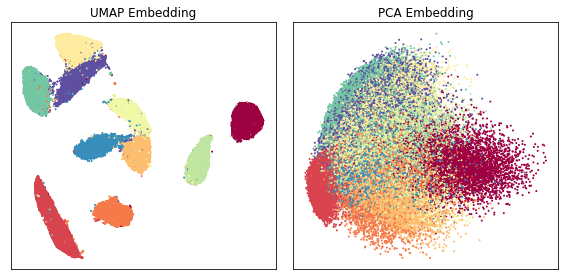

In [4]:
import os
import pickle
from umap import UMAP
from sklearn.decomposition import PCA


def create_embeddings(data, ignore_cache=False):
    umap_dir = "cache/umap.pickle"
    pca_dir = "cache/pca.pickle"

    if not os.path.isfile(umap_dir) or ignore_cache:
        umap_reducer = UMAP(random_state=42).fit(data)
        pickle.dump(umap_reducer, open(umap_dir, "wb"))
    else:
        umap_reducer = pickle.load(open(umap_dir, "rb"))

    if not os.path.isfile(pca_dir) or ignore_cache:
        pca_reducer = PCA(n_components=2, random_state=42).fit(data)
        pickle.dump(pca_reducer, open(pca_dir, "wb"))
    else:
        pca_reducer = pickle.load(open(pca_dir, "rb"))
        
    return umap_reducer, pca_reducer


umap_reducer, pca_reducer = create_embeddings(train_x, ignore_cache=False)
umap_data = umap_reducer.transform(train_x)
pca_data = pca_reducer.transform(train_x)

fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].scatter(umap_data[:,0], umap_data[:,1], s=1, c=train_labels, cmap='Spectral')
axes[0].set_title("UMAP Embedding")

axes[1].scatter(pca_data[:,0], pca_data[:,1], s=1, c=train_labels, cmap='Spectral')
axes[1].set_title("PCA Embedding")
plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()

In [5]:
def random_parameters(data, num_rules):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    init_mu = (data_max - data_min) * np.random.rand(num_rules, data.shape[1]) + data_min
    init_sigma = np.ones((num_rules, 1)) + (data_max - data_min)
    return init_mu, init_sigma


init_mu, init_sigma = random_parameters(train_x, 10)
model = create_model(init_mu, init_sigma)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

random_history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=64,
    epochs=50,
    verbose=1,
    shuffle=True)

W0211 15:58:14.265258 139982919419712 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Epoch 1/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.3317 - categorical_accuracy: 0.3693
Epoch 2/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.2319 - categorical_accuracy: 0.7498
Epoch 3/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1817 - categorical_accuracy: 0.8098
Epoch 4/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.1476 - categorical_accuracy: 0.8412
Epoch 5/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1248 - categorical_accuracy: 0.8617
Epoch 6/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1088 - categorical_accuracy: 0.8767
Epoch 7/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.0967 - categorical_accuracy: 0.8907
Epoch 8/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.0871 - categorical_accuracy: 0.8992
Epoch 9/50
60000/60000 [==============================] - 3s 45u

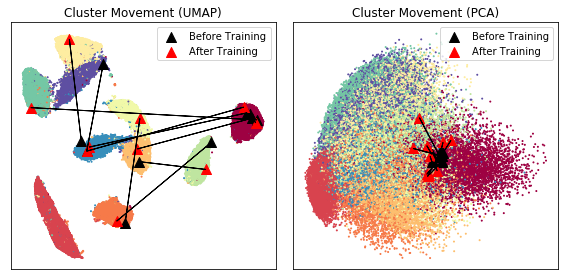

In [6]:
def plot_cluster_movement(ax, data, init, current):
    change = current - init
    
    ax.scatter(data[:,0], data[:,1], s=1, c=train_labels, cmap='Spectral')
    s1 = ax.scatter(init[:,0], init[:,1], s=100, c="k", marker="^")
    s2 = ax.scatter(current[:,0], current[:,1], s=100, c="r", marker="^")
    
    for i in range(change.shape[0]):
        ax.arrow(init[i,0], init[i,1], change[i,0], change[i,1])
    ax.legend([s1, s2], ["Before Training", "After Training"])


current_mu = model.layers[0].get_weights()[0]

fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].set_title("Cluster Movement (UMAP)")
plot_cluster_movement(
    axes[0], umap_data,
    umap_reducer.transform(init_mu), 
    umap_reducer.transform(current_mu))

axes[1].set_title("Cluster Movement (PCA)")
plot_cluster_movement(
    axes[1], pca_data,
    pca_reducer.transform(init_mu), 
    pca_reducer.transform(current_mu))

plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()

In [7]:
import skfuzzy as skf


def fcm_parameters(data, c, m, ignore_cache=False):
    cache_dir = "cache/mu_fcm.pickle"
    
    if not os.path.isfile(cache_dir) or ignore_cache:
        centers, memberships, u0, d, jm, p, fpc = skf.cmeans(
            data.T, c, m, 1e-8, 1000, seed=0)
        pickle.dump(centers, open(cache_dir, "wb"))
    else:
        centers = pickle.load(open(cache_dir, "rb"))
        
    sigmas = np.ones((c, data.shape[1]))
    return centers, sigmas


init_mu, init_sigma = fcm_parameters(train_x, 10, 1.1)
model = create_model(init_mu, init_sigma)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

fcm_history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=64,
    epochs=50,
    verbose=1,
    shuffle=True)

Epoch 1/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.4134 - categorical_accuracy: 0.1957
Epoch 2/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.2860 - categorical_accuracy: 0.3739
Epoch 3/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.2554 - categorical_accuracy: 0.4510
Epoch 4/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.2068 - categorical_accuracy: 0.6725
Epoch 5/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1406 - categorical_accuracy: 0.8269
Epoch 6/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1158 - categorical_accuracy: 0.8710
Epoch 7/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1003 - categorical_accuracy: 0.8943
Epoch 8/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.0893 - categorical_accuracy: 0.9030
Epoch 9/50
60000/60000 [==============================] - 3s 45u

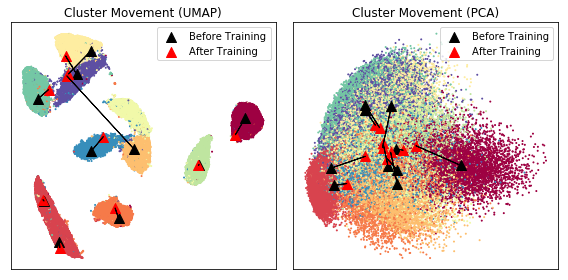

In [8]:
current_mu = model.layers[0].get_weights()[0]

fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].set_title("Cluster Movement (UMAP)")
plot_cluster_movement(
    axes[0], umap_data,
    umap_reducer.transform(init_mu), 
    umap_reducer.transform(current_mu))

axes[1].set_title("Cluster Movement (PCA)")
plot_cluster_movement(
    axes[1], pca_data,
    pca_reducer.transform(init_mu), 
    pca_reducer.transform(current_mu))

plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()

In [16]:
import GK as gk


def gk_parameters(data, c, m, ignore_cache=False):
    cache_dir = "cache/mu_gk.pickle"
    
    if not os.path.isfile(cache_dir) or ignore_cache:
        centers, memberships, u0, d, jm, p, fpc = gk.cmeans(
            data.T, c, m, 1e-8, 1000, seed=0)
        pickle.dump(centers, open(cache_dir, "wb"))
    else:
        centers = pickle.load(open(cache_dir, "rb"))
        
    sigmas = np.ones((c, data.shape[1]))
    return centers, sigmas


init_mu, init_sigma = gk_parameters(train_x, 10, 2.0, ignore_cache=True)
model = create_model(init_mu, init_sigma)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

gk_history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=64,
    epochs=50,
    verbose=1,
    shuffle=True)

Error Threshold 2
Epoch 1/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.3355 - categorical_accuracy: 0.3814
Epoch 2/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2213 - categorical_accuracy: 0.7815
Epoch 3/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1685 - categorical_accuracy: 0.8379
Epoch 4/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1354 - categorical_accuracy: 0.8630
Epoch 5/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1127 - categorical_accuracy: 0.8811
Epoch 6/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.0966 - categorical_accuracy: 0.8947
Epoch 7/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.0850 - categorical_accuracy: 0.9052
Epoch 8/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.0768 - categorical_accuracy: 0.9110
Epoch 9/50
60000/60000 [======================

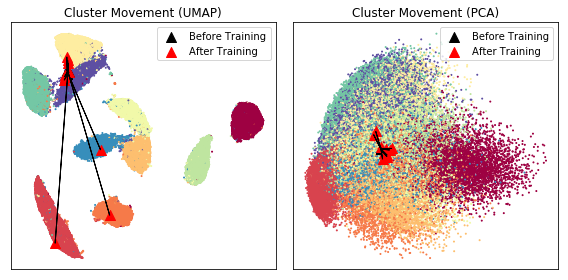

In [17]:
current_mu = model.layers[0].get_weights()[0]

fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].set_title("Cluster Movement (UMAP)")
plot_cluster_movement(
    axes[0], umap_data,
    umap_reducer.transform(init_mu), 
    umap_reducer.transform(current_mu))

axes[1].set_title("Cluster Movement (PCA)")
plot_cluster_movement(
    axes[1], pca_data,
    pca_reducer.transform(init_mu), 
    pca_reducer.transform(current_mu))

plt.setp(axes, xticks=[], yticks=[])
plt.tight_layout()

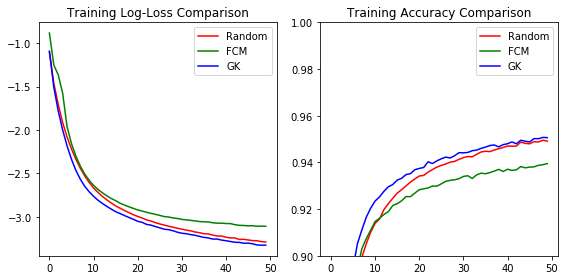

In [20]:
fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].set_title("Training Log-Loss Comparison")
axes[0].plot(np.log(random_history.history["loss"]), c="r")
axes[0].plot(np.log(fcm_history.history["loss"]), c="g")
axes[0].plot(np.log(gk_history.history["loss"]), c="b")
axes[0].legend(["Random", "FCM", "GK"])

axes[1].set_title("Training Accuracy Comparison")
axes[1].set_ylim((0.9, 1))
axes[1].plot(random_history.history["categorical_accuracy"], c="r")
axes[1].plot(fcm_history.history["categorical_accuracy"], c="g")
axes[1].plot(gk_history.history["categorical_accuracy"], c="b")
axes[1].legend(["Random", "FCM", "GK"])

plt.tight_layout()